## Librerias

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

## Funciones

In [2]:
def covarianza(x_, y_):
  x_media_ = x_.mean()
  y_media_ = y_.mean()
  n = len(x_)
  covar = (((x_ - x_media_) * (y_ - y_media_)).sum()) / (n - 1)
  return covar

In [3]:
def matriz_covarianza(datos_):
  atributos_ = datos_.columns
  n_ = len(atributos_)
  matriz_ = np.zeros((n_, n_))
  for i, atr_i in enumerate(atributos_):
    for j, atr_j in enumerate(atributos_):
      xmc_ = datos_[atr_i]
      ymc_ = datos_[atr_j]
      matriz_[i, j] = covarianza(xmc_, ymc_)
  return matriz_

In [4]:
def split_80_20(datos_, etiquetas_):
  n_ = len(datos_)
  indices_ = np.arange(n_)
  np.random.shuffle(indices_)
  lim = int(n_ * 0.80) + 1
  x_train_ = datos_[indices_[0:lim]]
  x_test_ = datos_[indices_[lim:]]
  y_train_ = etiquetas_[indices_[0:lim]]
  y_test_ = etiquetas_[indices_[lim:]]
  return x_train_, x_test_, y_train_, y_test_

In [5]:
def split_k_fold(datos_, folds_):
  n_ = len(datos_)
  indices_ = np.arange(n_)
  np.random.shuffle(indices_)
  f = n_ // folds_
  indices_train_ = np.zeros((folds_, n_ - f - 1))
  indices_test_ = np.zeros((folds_, f + 1))
  for i in range (folds_):
    lim_inf = i * f
    lim_sup = 1 + (lim_inf + f)
    ind = np.arange(lim_inf, lim_sup)
    indices_train_[i] = np.delete(indices_, ind)
    indices_test_[i] = indices_[ind]
  return indices_train_, indices_test_

In [6]:
def exactitud(y_calculada_, y_real_):
  coincidencias = np.equal(y_calculada_, y_real_)
  total_coin_ = np.sum(coincidencias)
  porcentaje_ = (total_coin_ / len(y_calculada_))
  return porcentaje_

In [7]:
def precision(y_clas_, y_real_):
  TP = 0
  FP = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 1: TP += 1
    elif (r != c) and r == 0: FP += 1
  pre_ = TP / (TP + FP)
  return pre_

In [8]:
def sensitividad(y_clas_, y_real_):
  TP_ = 0
  FN_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 1: TP_ += 1
    elif (r != c) and r == 1: FN_ += 1
  sens_ = TP_ / (TP_ + FN_)
  return sens_

In [9]:
def especificidad(y_clas_, y_real_):
  TN_ = 0
  FP_ = 0
  for c, r in zip(y_clas_, y_real_):
    if (r == c) and r == 0: TN_ += 1
    elif (r != c) and r == 0: FP_ += 1
  esp_ = TN_ / (TN_ + FP_)
  return esp_

In [10]:
def puntaje_F1(y_clas_, y_real_):
  prec_ = precision(y_clas_, y_real_)
  sens_ = sensitividad(y_clas_, y_real_)
  pf1_ = 2 * ((prec_ * sens_) / (prec_ + sens_))
  return pf1_

In [11]:
def MSE(y_real_, y_clas_):
  l2 = np.sum((y_clas_ - y_real_)**2) / (2 * len(y_real_))
  return l2

In [12]:
# Distancia euclidiana
def distancia_euclidiana(puntos_, c_):
  n_ = len(puntos_)
  de_ = np.zeros(n_)
  for p in range(n_):
    suma_cuadrados_ = sum((puntos_[p] - c_) ** 2)
    de_[p] = np.sqrt(suma_cuadrados_)
  de_ = pd.DataFrame(de_)
  return de_

In [13]:
def pertenencia(distancias_, Y_, k_):
  distancias_min_max_ = distancias_.sort_values(0)
  vecinos_cercanos_ = distancias_min_max_.index.values[1:k_ + 1]
  Y_vecinos_ = Y_[vecinos_cercanos_].tolist()
  y_clasificacion_ = np.bincount(Y_vecinos_).argmax()
  return y_clasificacion_

In [14]:
# Entrenar
def entrenamiento(x_ent_, y_ent_, k_max_):
  numero_clases_ = len(np.unique(y_ent_))
  n_ = len(x_ent_)
  exactitudes_ = np.zeros(k_max_ - numero_clases_)
  for i in tqdm(range(numero_clases_ + 1, k_max_ + 1)):
    y_clas_train_ = np.zeros(n_)
    for j in range(n_):
      distancias_p_ = distancia_euclidiana(x_ent_, x_ent_[j])
      y_clas_train_[j] = pertenencia(distancias_p_, y_ent_, i)
    exactitudes_[i - k_max_ - 1] = exactitud(y_clas_train_, y_ent_)
  #print(exactitudes_)
  max_exactitud_ = max(exactitudes_)
  #print(max_exactitud_)
  indices_ = np.where(exactitudes_ == max_exactitud_)
  #print(indices_)
  if len(indices_[0]) > 1: indices_ = indices_[0]
  indices_ = int(indices_[0])
  mejores_vecinos_ = indices_ + numero_clases_ + 1
  return exactitudes_, max_exactitud_, mejores_vecinos_

In [15]:
def clasificar(x_test_, x_train_, y_train_, k_):
  n_ = len(x_test_)
  y_clas_ = np.zeros(n_)
  for i in tqdm(range(n_)):
    distancias_p_ = distancia_euclidiana(x_train_, x_test_[i])
    y_clas_[i] = pertenencia(distancias_p_, y_train_, k_)
  return y_clas_

## Base de datos (Titanic)

In [16]:
df = pd.read_csv("/content/drive/MyDrive/Bases_de_Datos/Titanic/train.csv")
print("Dimensión:",df.shape)
df.head()

Dimensión: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ya que el nombre del pasajero, el ID y el ticket es información individual se eliminan ya que no proporcionan gran información. De igual forma se elimina la columna de las cabinas ya que más del 77 por ciento de la información dada por esta característica es nula.

In [18]:
df = df.drop(['Name','PassengerId','Ticket', 'Cabin'],axis = 1)

Ya que la categoría de Sexo y lugar de embarcación contienen la información en caracteres alfabéticos se cambiará a caracteres numéricos.

In [19]:
df['Sex'] = df['Sex'].replace(['male', 'female'], [1, 0])
df['Embarked'] = df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0.0
1,1,1,0,38.0,1,0,71.2833,1.0
2,1,3,0,26.0,0,0,7.9250,0.0
3,1,1,0,35.0,1,0,53.1000,0.0
4,0,3,1,35.0,0,0,8.0500,0.0


In [20]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [21]:
x = df.copy()
x.drop(['Survived'], axis = 1, inplace = True)
atb = list(x.columns)

In [22]:
atb

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

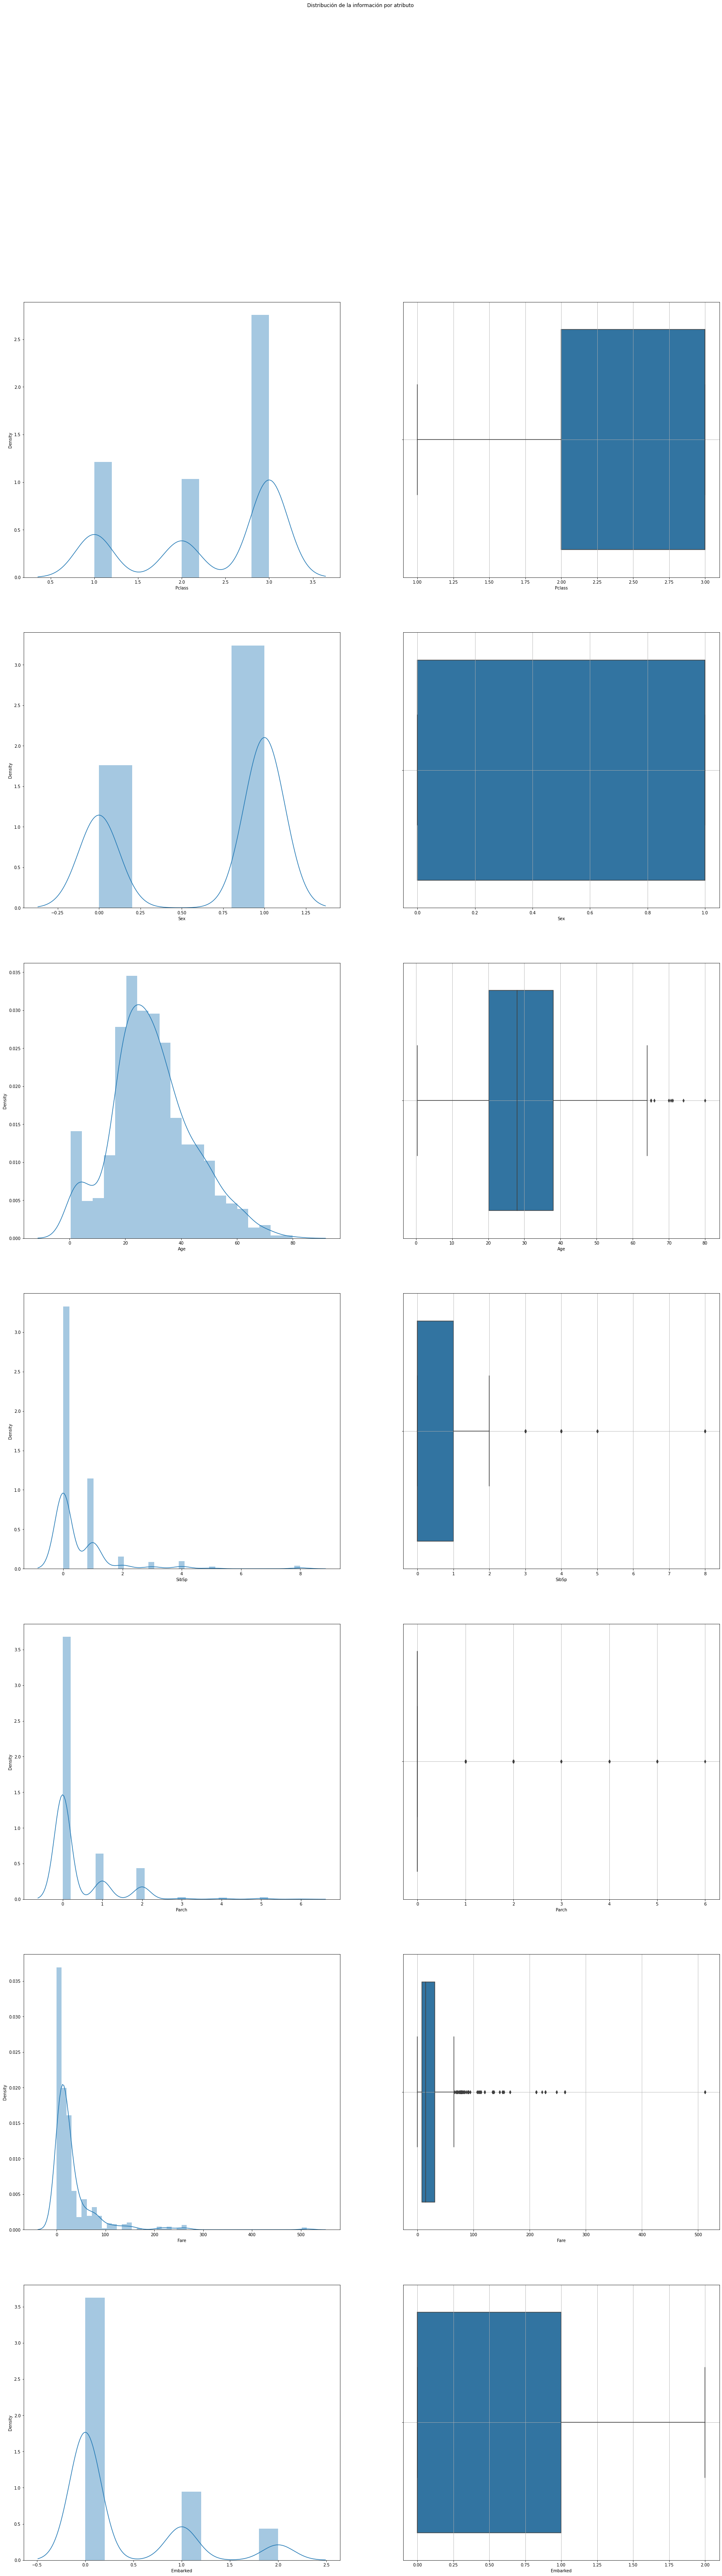

In [23]:
fig, axes = plt.subplots(x.shape[1], 2, figsize = (30,100))
fig.suptitle('Distribución de la información por atributo')
for i, c in enumerate(atb):
  dist_datos = df[c].dropna()
  sns.boxplot(dist_datos, ax = axes[i, 1])
  sns.distplot(dist_datos, ax = axes[i, 0])
  #axes[i, 1].boxplot(x[c].dropna())
  axes[i, 1].grid(True)

Para los datos faltantes de realiza una imputaciòn por media.

In [24]:
media_años = df['Age'].mean()
media_embarcacion = round(df['Embarked']. mean())

In [25]:
df['Age'] = df['Age'].fillna(media_años)
df['Embarked'] = df['Embarked'].fillna(media_embarcacion)

In [26]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Se grafican los dos atributos en los cuales se realizó la imputación para verificar que la distribución de los mismos no se modifico significativamente. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

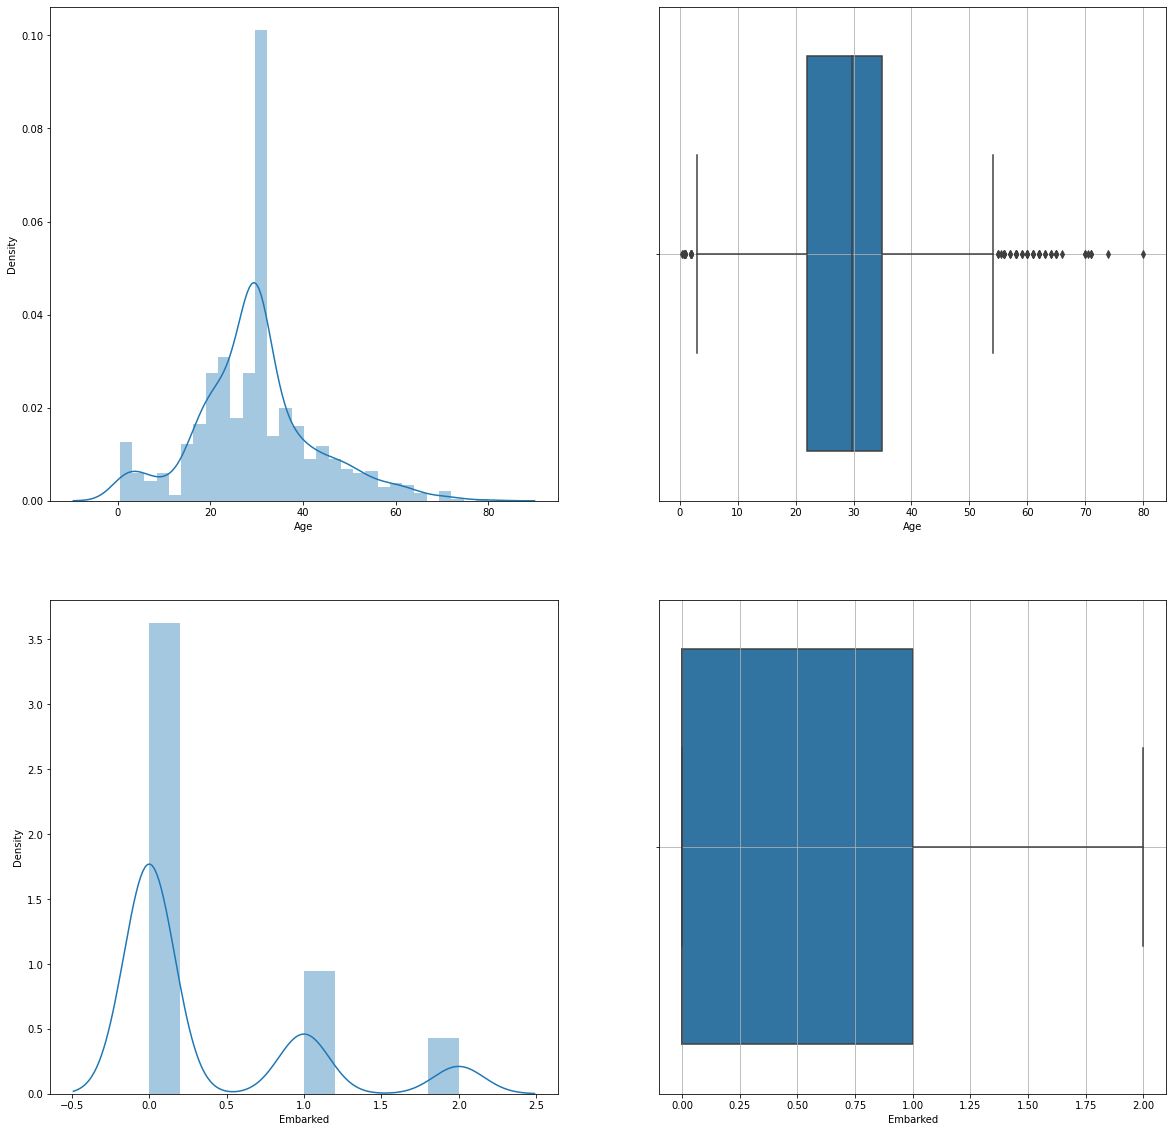

In [27]:
fig, axes = plt.subplots(2, 2, figsize = (20,20))
for i, c in enumerate(['Age', 'Embarked']):
  dist_datos = df[c]
  sns.boxplot(dist_datos, ax = axes[i, 1])
  sns.distplot(dist_datos, ax = axes[i, 0])
  axes[i, 1].grid(True)

Normalización de los datos

In [28]:
df_maximos = df.max() 
df_minimos = df.min()
df_rango = df_maximos - df_minimos
df = (df - df_minimos) / df_rango

In [29]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.271174,0.125,0.000000,0.014151,0.0
1,1.0,0.0,0.0,0.472229,0.125,0.000000,0.139136,0.5
2,1.0,1.0,0.0,0.321438,0.000,0.000000,0.015469,0.0
3,1.0,0.0,0.0,0.434531,0.125,0.000000,0.103644,0.0
4,0.0,1.0,1.0,0.434531,0.000,0.000000,0.015713,0.0
...,...,...,...,...,...,...,...,...
886,0.0,0.5,1.0,0.334004,0.000,0.000000,0.025374,0.0
887,1.0,0.0,0.0,0.233476,0.000,0.000000,0.058556,0.0
888,0.0,1.0,0.0,0.367921,0.125,0.333333,0.045771,0.0
889,1.0,0.0,1.0,0.321438,0.000,0.000000,0.058556,0.5


PCA

In [30]:
X = df.drop(['Survived'], axis = 1)
X_ajs = X - X.mean()

In [31]:
m_covarianza = matriz_covarianza(X_ajs)

In [32]:
m_covarianza

array([[ 0.17475378,  0.02635594, -0.0226304 ,  0.00478742,  0.00103574,
        -0.02228079,  0.00607227],
       [ 0.02635594,  0.22847451,  0.006572  , -0.00755274, -0.01576397,
        -0.00845344, -0.01770955],
       [-0.0226304 ,  0.006572  ,  0.02669399, -0.00523898, -0.00393312,
         0.00145108,  0.00038746],
       [ 0.00478742, -0.00755274, -0.00523898,  0.01900067,  0.00768205,
         0.00213455, -0.002627  ],
       [ 0.00103574, -0.01576397, -0.00393312,  0.00768205,  0.01804801,
         0.00281754, -0.00335891],
       [-0.02228079, -0.00845344,  0.00145108,  0.00213455,  0.00281754,
         0.00940805,  0.00191574],
       [ 0.00607227, -0.01770955,  0.00038746, -0.002627  , -0.00335891,
         0.00191574,  0.10102019]])

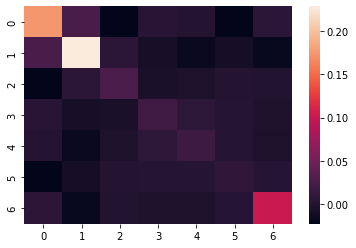

In [33]:
sns.heatmap(m_covarianza)

In [34]:
L, V = np.linalg.eig(m_covarianza)
porcentajes = (L / L.sum()) * 100
porcentajes

array([42.0589233 , 29.85370112, 17.04686433,  5.00491112,  3.24547827,
        0.95680078,  1.83332108])

In [35]:
porcentajes[0:4].sum()

93.96439986531139

## KNN

In [36]:
df = df.drop(['Parch', 'Fare', 'Embarked'], axis = 1)

In [37]:
df

,Survived,Pclass,Sex,Age,SibSp
0,0.0,1.0,1.0,0.271174,0.125
1,1.0,0.0,0.0,0.472229,0.125
2,1.0,1.0,0.0,0.321438,0.000
3,1.0,0.0,0.0,0.434531,0.125
4,0.0,1.0,1.0,0.434531,0.000
...,...,...,...,...,...
886,0.0,0.5,1.0,0.334004,0.000
887,1.0,0.0,0.0,0.233476,0.000
888,0.0,1.0,0.0,0.367921,0.125
889,1.0,0.0,1.0,0.321438,0.000


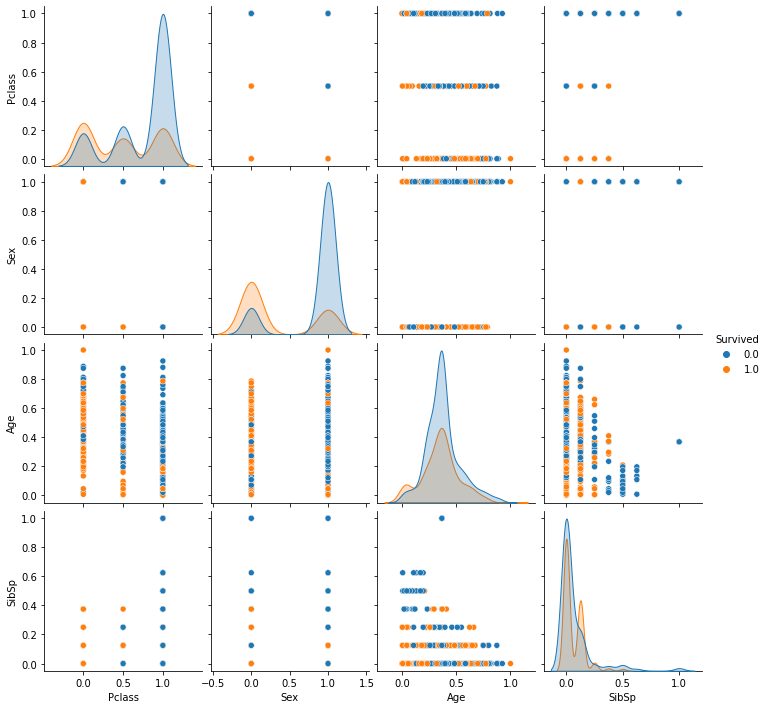

In [38]:
sns.pairplot(df, vars=df.columns[1:], hue=df.columns[0])

In [39]:
X = np.asarray(df.drop(['Survived'], axis = 1))
Y = np.asarray(df['Survived'])

### Separación 80 - 20

In [40]:
x_train_80, x_test_20, y_train_80, y_test_20 = split_80_20(X, Y)

In [41]:
e, me, mv = entrenamiento(x_train_80, y_train_80, 30)
print(f'''La mejor exactitud se obtiene con {mv} vecinos.
Con una exactitud de {me}''')

100%|██████████| 28/28 [01:28<00:00,  3.17s/it]

La mejor exactitud se obtiene con 7 vecinos.
Con una exactitud de 0.8190743338008415


Text(0, 0.5, 'Exactitud')

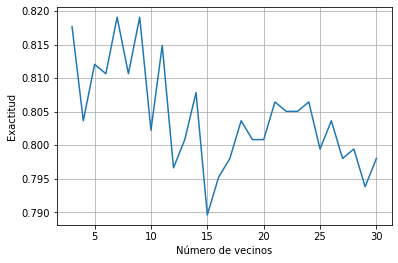

In [42]:
plt.figure()
plt.plot(np.arange(3, 31), e)
plt.grid(True)
plt.xlabel('Número de vecinos')
plt.ylabel('Exactitud')

#### test


In [43]:
y_clas_knn = clasificar(x_test_20, x_train_80, y_train_80, mv)

100%|██████████| 178/178 [00:00<00:00, 192.91it/s]


In [44]:
exactitud_test = exactitud(y_clas_knn, y_test_20)
error_cuad_test = MSE(y_test_20, y_clas_knn)
precision_test = precision(y_clas_knn, y_test_20)
sensitividad_test = sensitividad(y_clas_knn, y_test_20)
especificidad_test = especificidad (y_clas_knn, y_test_20)
f1_test = puntaje_F1(y_clas_knn, y_test_20)

In [45]:
print(f'''La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: {exactitud_test}
Precisión: {precision_test}
Sensitividad: {sensitividad_test}
Especificidad: {especificidad_test}
Puntaje F1: {f1_test}
Error cuadrático medio: {error_cuad_test}''')

La evaluación del modelo diseñado nos indica que se tienen las iguientes cifras de mérito:
Exactitud: 0.8146067415730337
Precisión: 0.8909090909090909
Sensitividad: 0.6447368421052632
Especificidad: 0.9411764705882353
Puntaje F1: 0.7480916030534351
Error cuadrático medio: 0.09269662921348315


### Separación K-fold

##### k-fold 5

In [55]:
folds = 5
indices_entrenamiento, indices_validacion = split_k_fold(X, folds)
indices_entrenamiento = indices_entrenamiento.astype(int)
indices_validacion = indices_validacion.astype(int)

In [60]:
exactitudes_kf = np.zeros((folds, 28))
exactitudes_entrenamiento = np.zeros(folds)
mv_kf = np.zeros(folds)
exactitud_test_kf = np.zeros(folds)
error_cuad_test_kf = np.zeros(folds)
precision_test_kf = np.zeros(folds)
sensitividad_test_kf = np.zeros(folds)
especificidad_test_kf = np.zeros(folds)
f1_test_kf = np.zeros(folds)
for i in range(folds):
  exactitudes_kf[i], exactitudes_entrenamiento[i], mv_kf[i] = entrenamiento(
     X[indices_entrenamiento[i]], Y[indices_entrenamiento[i]], 30)
  print(mv_kf[i])
  y_clas_knn_kf = clasificar(X[indices_validacion[i]],
                             X[indices_entrenamiento[i]],
                             Y[indices_entrenamiento[i]], 
                             mv_kf[i].astype(int))
  exactitud_test_kf[i] = exactitud(y_clas_knn_kf, Y[indices_validacion[i]])
  error_cuad_test_kf[i] = MSE(Y[indices_validacion[i]], y_clas_knn_kf)
  precision_test_kf[i] = precision(y_clas_knn_kf, Y[indices_validacion[i]])
  sensitividad_test_kf[i] = sensitividad(y_clas_knn_kf, Y[indices_validacion[i]])
  especificidad_test_kf[i] = especificidad (y_clas_knn_kf, Y[indices_validacion[i]])
  f1_test_kf[i] = puntaje_F1(y_clas_knn_kf,Y[indices_validacion[i]])

100%|██████████| 28/28 [01:26<00:00,  3.07s/it]


4.0


100%|██████████| 28/28 [01:26<00:00,  3.09s/it]


4.0


100%|██████████| 28/28 [01:27<00:00,  3.11s/it]


3.0


100%|██████████| 28/28 [01:27<00:00,  3.11s/it]


3.0


100%|██████████| 28/28 [01:26<00:00,  3.09s/it]


5.0


100%|██████████| 179/179 [00:00<00:00, 200.11it/s]


In [61]:
exactitud_kf = exactitud_test_kf.mean()
error_cuad_kd = error_cuad_test_kf.mean()
precision_kf = precision_test_kf.mean()
sensitividad_kf = sensitividad_test_kf.mean()
especificidad_kf = especificidad_test_kf.mean()
f1_kf = f1_test_kf.mean()

In [63]:
print(f'''La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: {exactitud_kf}
Precisión: {precision_kf}
Sensitividad: {sensitividad_kf}
Especificidad: {especificidad_kf}
Puntaje F1: {f1_kf}
Error cuadrático medio: {error_cuad_kd}''')

La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: 0.805586592178771
Precisión: 0.7841872739841911
Sensitividad: 0.6980685980685981
Especificidad: 0.8769034305327933
Puntaje F1: 0.7327781995796088
Error cuadrático medio: 0.09720670391061452


##### k-fold 10

In [69]:
folds = 10
indices_entrenamiento_10, indices_validacion_10 = split_k_fold(X, folds)
indices_entrenamiento_10 = indices_entrenamiento_10.astype(int)
indices_validacion_10 = indices_validacion_10.astype(int)

In [70]:
exactitudes_kf_10 = np.zeros((folds, 28))
exactitudes_entrenamiento_10 = np.zeros(folds)
mv_kf_10 = np.zeros(folds)
exactitud_test_kf_10 = np.zeros(folds)
error_cuad_test_kf_10 = np.zeros(folds)
precision_test_kf_10 = np.zeros(folds)
sensitividad_test_kf_10 = np.zeros(folds)
especificidad_test_kf_10 = np.zeros(folds)
f1_test_kf_10 = np.zeros(folds)
for i in range(folds):
  exactitudes_kf_10[i], exactitudes_entrenamiento_10[i], mv_kf_10[i] = entrenamiento(
     X[indices_entrenamiento_10[i]], Y[indices_entrenamiento_10[i]], 30)
  #print(mv_kf[i])
  y_clas_knn_kf_10 = clasificar(X[indices_validacion_10[i]],
                                X[indices_entrenamiento_10[i]],
                                Y[indices_entrenamiento_10[i]], 
                                mv_kf_10[i].astype(int))
  exactitud_test_kf_10[i] = exactitud(y_clas_knn_kf_10, Y[indices_validacion_10[i]])
  error_cuad_test_kf_10[i] = MSE(Y[indices_validacion_10[i]], y_clas_knn_kf_10)
  precision_test_kf_10[i] = precision(y_clas_knn_kf_10, Y[indices_validacion_10[i]])
  sensitividad_test_kf_10[i] = sensitividad(y_clas_knn_kf_10, Y[indices_validacion_10[i]])
  especificidad_test_kf_10[i] = especificidad (y_clas_knn_kf_10, Y[indices_validacion_10[i]])
  f1_test_kf_10[i] = puntaje_F1(y_clas_knn_kf_10,Y[indices_validacion_10[i]])

100%|██████████| 90/90 [00:00<00:00, 194.35it/s]


In [71]:
exactitud_kf_10 = exactitud_test_kf_10.mean()
error_cuad_kd_10 = error_cuad_test_kf_10.mean()
precision_kf_10 = precision_test_kf_10.mean()
sensitividad_kf_10 = sensitividad_test_kf_10.mean()
especificidad_kf_10 = especificidad_test_kf_10.mean()
f1_kf_10 = f1_test_kf_10.mean()

In [72]:
print(f'''La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: {exactitud_kf_10}
Precisión: {precision_kf_10}
Sensitividad: {sensitividad_kf_10}
Especificidad: {especificidad_kf_10}
Puntaje F1: {f1_kf_10}
Error cuadrático medio: {error_cuad_kd_10}''')

La evaluación del modelo diseñado nos indica que se tienen las siguientes cifras de mérito:
Exactitud: 0.8099999999999999
Precisión: 0.7993171612975725
Sensitividad: 0.6843202888791124
Especificidad: 0.8883495038170544
Puntaje F1: 0.7298240369257198
Error cuadrático medio: 0.095


In [73]:
mv_kf_10

array([4., 5., 8., 3., 3., 3., 8., 3., 4., 4.])